In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib widget
import pandas as pd

df = pd.read_hdf('data/binance_BTC_USDT.h5')

  0%|          | 0/2760153 [00:00<?, ?it/s]

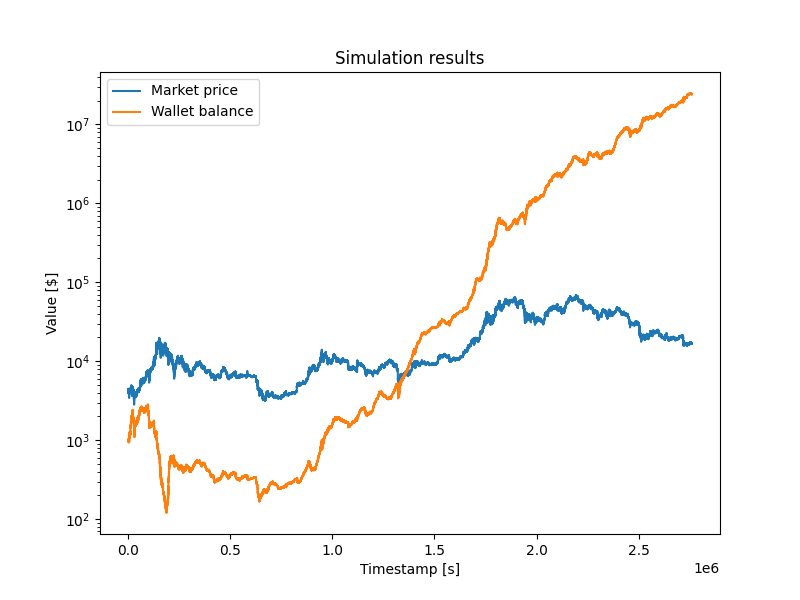

In [3]:
from simulation import simulation, plot_sim_results
from strategy import BaselineStrategy, RandomStrategy

prices = df['price'].to_numpy()
balance, _, _, trajectory = simulation(prices=prices,
                                       initial_balance=1000,
                                       strategy=BaselineStrategy())

# Somehow the strategy makes too much money, so I need to use log scale
plot_sim_results(prices, trajectory, log_scale=True)

## What happens if we add trading fees to the mix?

  0%|          | 0/2760153 [00:00<?, ?it/s]

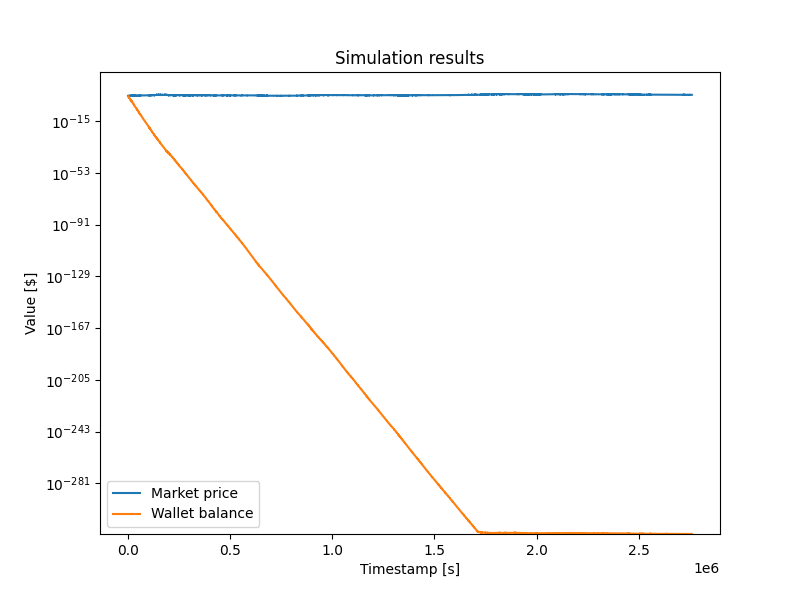

In [4]:
prices = df['price'].to_numpy()
balance, _, _, trajectory = simulation(prices=prices,
                                       initial_balance=1000,
                                       strategy=BaselineStrategy(),
                                       fee=0.001)

# Somehow the strategy makes too much money, so I need to use log scale
plot_sim_results(prices, trajectory, log_scale=True)

## Okay then maybe trading on each minute is not the way to go, let's make the strategy trade less

##### Threshold 0.005

  0%|          | 0/2760153 [00:00<?, ?it/s]

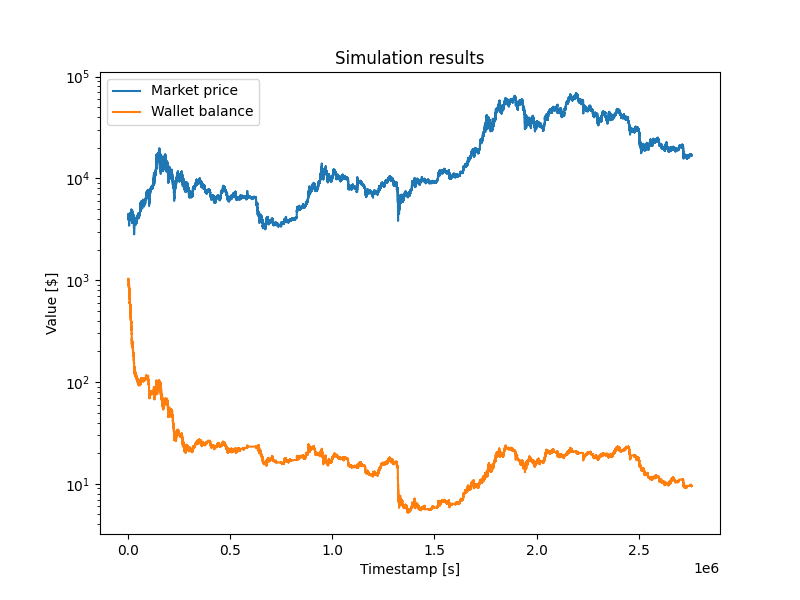

In [5]:
prices = df['price'].to_numpy()
balance, _, _, trajectory = simulation(prices=prices,
                                       initial_balance=1000,
                                       strategy=BaselineStrategy(0.005),
                                       fee=0.001)

# Somehow the strategy makes too much money, so I need to use log scale
plot_sim_results(prices, trajectory, log_scale=True)

##### Threshold 0.01

  0%|          | 0/2760153 [00:00<?, ?it/s]

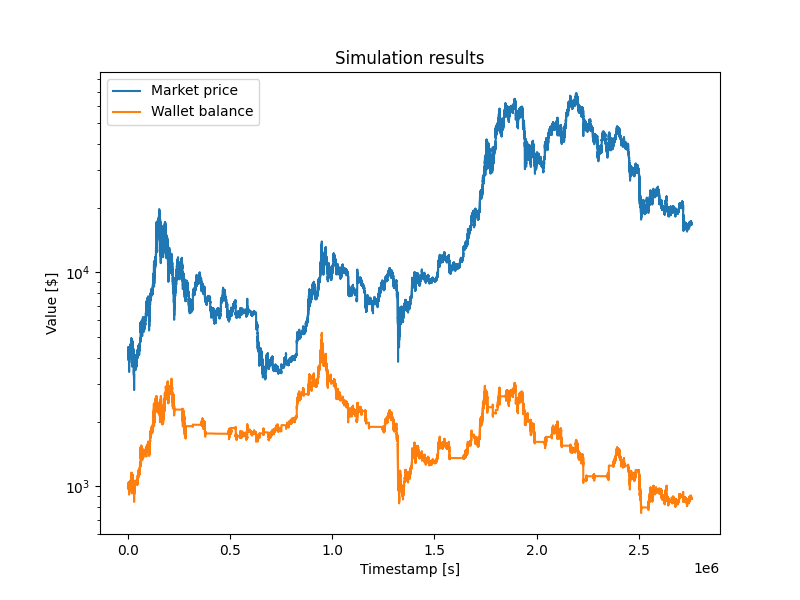

In [6]:
prices = df['price'].to_numpy()
balance, _, _, trajectory = simulation(prices=prices,
                                       initial_balance=1000,
                                       strategy=BaselineStrategy(0.01),
                                       fee=0.001)

# Somehow the strategy makes too much money, so I need to use log scale
plot_sim_results(prices, trajectory, log_scale=True)

##### Threshold 0.02

  0%|          | 0/2760153 [00:00<?, ?it/s]

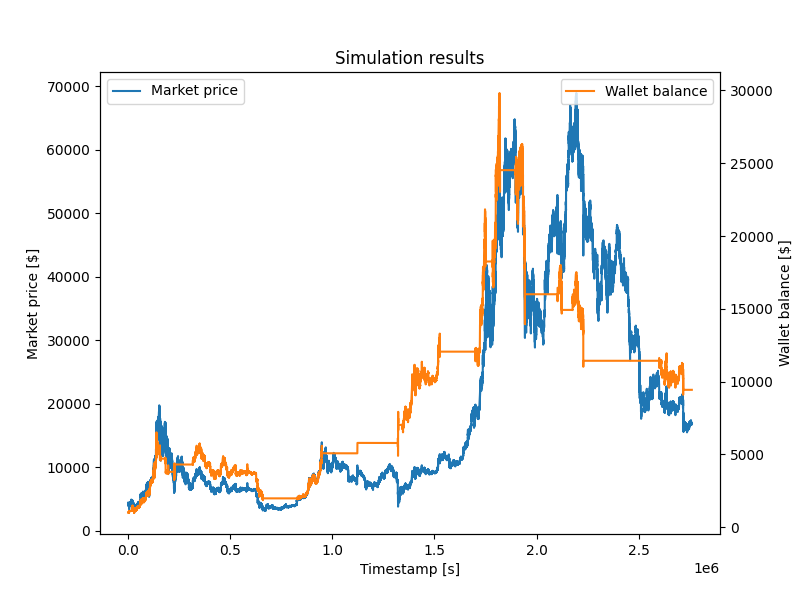

In [7]:
from simulation import plot_sim_results
prices = df['price'].to_numpy()
balance, _, _, trajectory = simulation(prices=prices,
                                       initial_balance=1000,
                                       strategy=BaselineStrategy(0.02),
                                       fee=0.001)

# Somehow the strategy makes too much money, so I need to use log scale
plot_sim_results(prices, trajectory, twin_axes=True)

  0%|          | 0/2760153 [00:00<?, ?it/s]

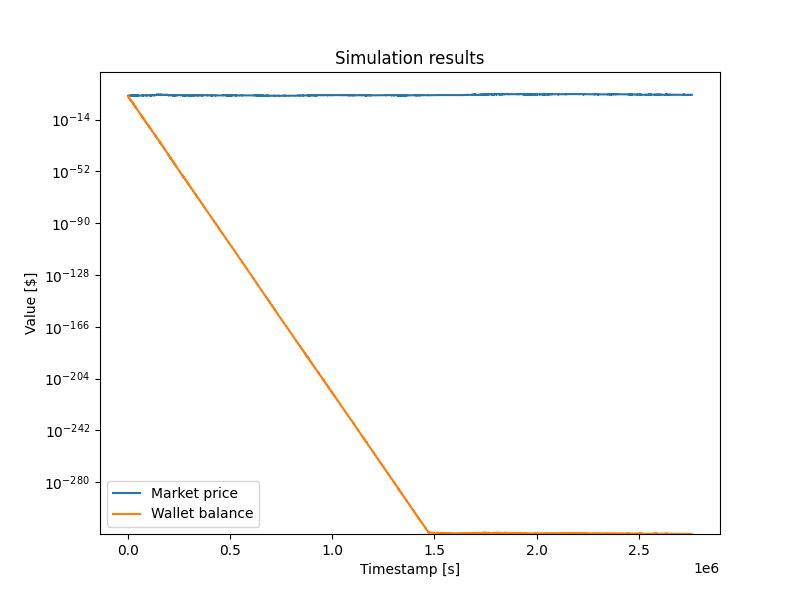

In [8]:
balance, _, _, trajectory = simulation(prices=prices,
                                       initial_balance=1000,
                                       strategy=RandomStrategy(),
                                       fee=0.001)

# There it usually just copies the market price but has different scale hence twin_axes look better
plot_sim_results(prices, trajectory, log_scale=True)

In [3]:
ONE_MONTH_IN_SEC = 2592000
eval_period = df.loc[df.index[-1] - 6 * ONE_MONTH_IN_SEC:]
eval_prices = eval_period['price'].to_numpy()

  0%|          | 0/259201 [00:00<?, ?it/s]

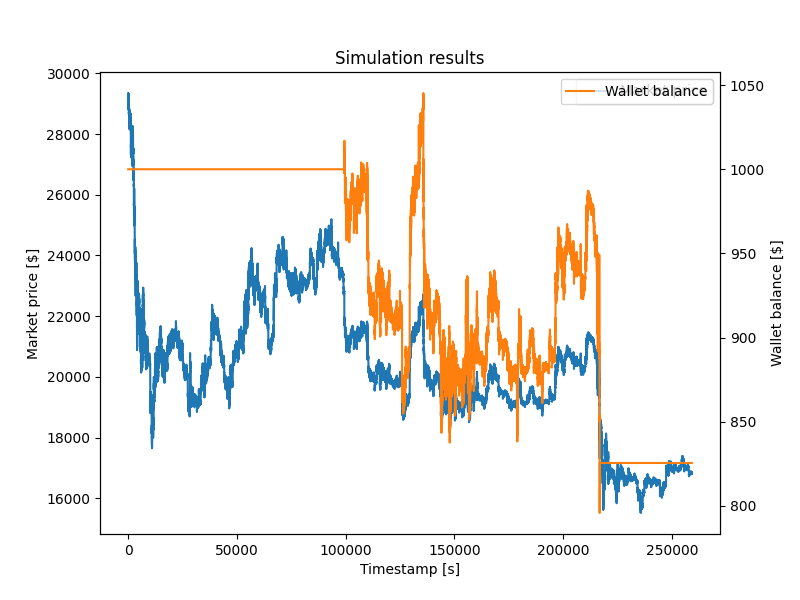

In [4]:
balance, _, _, trajectory = simulation(prices=eval_prices,
                                       initial_balance=1000,
                                       strategy=BaselineStrategy(threshold=0.02),
                                       fee=0.001)

# Even on eval period (last half a year) I get almost linear growth
plot_sim_results(eval_prices, trajectory, twin_axes=True)

## Temporal Convolutions

In [4]:
train_period = df.loc[:df.index[-1] - 9 * ONE_MONTH_IN_SEC]
train_prices = train_period['price']
validation_period = df.loc[df.index[-1] - 9 * ONE_MONTH_IN_SEC:df.index[-1] - 6 * ONE_MONTH_IN_SEC]
validation_prices = validation_period['price']

print(f"# train prices: {train_prices.size}")
print(f"# validation prices: {validation_prices.size}")
print(f"# evaluation prices: {eval_prices.size}")

# train prices: 2371353
# validation prices: 129601
# evaluation prices: 259201


In [5]:
#import tensorflow as tf
import numpy as np
import datetime
from typing import Iterator

#%load_ext tensorboard

In [7]:
def sliding_windows(data: pd.DataFrame, input_size) -> (np.ndarray, np.ndarray):
    shifted = []
    # Input: t-n-1, ..., t
    for i in reversed(range(input_size)):
        shifted.append(data.shift(i))
    shifted.append(data.shift(-1).pct_change())
    result = pd.concat(shifted, axis=1)
    result.dropna(inplace=True)
    return result.iloc[:, :-1].to_numpy()[..., np.newaxis] / 60_000, result.iloc[:, -1].to_numpy()


def sliding_windows_generator(data: pd.DataFrame, batch_size: int, input_size=1):
    for i in range(0, data.size, batch_size):
        sub_data = data.iloc[i:min(i + batch_size, data.size)]
        yield sliding_windows(sub_data, input_size)


class SlidingWindowsGenerator(tf.keras.utils.Sequence):
    def __init__(self, data: pd.DataFrame, batch_size: int, input_size: int):
        self.data = data
        self.batch_size = batch_size
        self.input_size = input_size

    def __getitem__(self, batch_idx):
        i = batch_idx * self.batch_size
        sub_data = self.data.iloc[i:min(i + self.batch_size, self.data.size)]
        return sliding_windows(sub_data, self.input_size)

    def __len__(self):
        return int(np.ceil(self.data.size / self.batch_size))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
device = torch.device('cuda:0')

class RandomWindowSamlper(Sampler):
    def __init__(self, data_length: int, batch_size: int, window_size: int):
        super().__init__(None)
        self.data_length = data_length - window_size
        self.batch_size = batch_size
        self.idxs = torch.LongTensor(range(data_length - window_size)).to(device)

    def _sample_indices(self):
        shuffled_idxs = torch.randperm(len(self.idxs), dtype=torch.long, device=device)
        return self.idxs[shuffled_idxs]

    def __iter__(self):
        indices = self._sample_indices()
        for batch_idx in range(self.data_length // self.batch_size):
            yield indices[batch_idx * self.batch_size: (batch_idx + 1) * self.batch_size]

    def __len__(self):
        return self.data_length // self.batch_size

class PriceDataSet(Dataset):
    def __init__(self, data: pd.DataFrame, window_size: int):
        super().__init__()
        self.data = torch.tensor(data.to_numpy()).float()
        self.window_size = window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        target = self.data[idx + self.window_size]
        return window, target

    def __len__(self):
        return len(self.data)

class PriceDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, window_size):
        super().__init__()
        self.batch_size = batch_size
        self.window_size = window_size

    def prepare_data(self) -> None:
        pass

    def setup(self, stage):
        df = pd.read_hdf('data/binance_BTC_USDT.h5')
        ONE_MONTH_IN_SEC = 2592000

        eval_period = df.loc[df.index[-1] - 6 * ONE_MONTH_IN_SEC:]
        eval_prices = eval_period['price'].to_numpy()

        train_period = df.loc[:df.index[-1] - 9 * ONE_MONTH_IN_SEC]
        train_prices = train_period['price']

        validation_period = df.loc[df.index[-1] - 9 * ONE_MONTH_IN_SEC:df.index[-1] - 6 * ONE_MONTH_IN_SEC]
        validation_prices = validation_period['price']

        self.train_dataset = PriceDataSet(train_prices, 64)
        self.val_dataset = PriceDataSet(validation_prices, 64)

    def train_dataloader(self):
        train_sampler = RandomWindowSamlper(len(self.train_dataset), self.batch_size, self.window_size)
        train_dataloader = DataLoader(self.train_dataset, batch_sampler=train_sampler)
        return train_dataloader

    def val_dataloader(self):
        val_sampler = RandomWindowSamlper(len(self.val_dataset), self.batch_size, self.window_size)
        val_dataloader = DataLoader(self.val_dataset, batch_sampler=val_sampler)
        return val_dataloader

class PredModel(pl.LightningModule):
    def __init__(self, window_size: int):
        super().__init__()
        self.window_size = window_size
        self.model = nn.Sequential(
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.smooth_l1_loss(y_hat, y.unsqueeze(1))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.smooth_l1_loss(y_hat, y.unsqueeze(1))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

dm = PriceDataModule(512, 64)
model = PredModel(64)

trainer = pl.Trainer(accelerator='gpu', devices=[0], logger=False, max_epochs=5)
trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/fassty/Devel/school/diploma_thesis/modelovani/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 34.1 K
----------------

Sanity Checking: 0it [00:00, ?it/s]

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [10]:
first_test_batch = next(iter(dm.val_dataloader()))

In [11]:
predicted = model(first_test_batch[0])
side_acc = []
errs = []
for input, target, pred in zip(first_test_batch[0], first_test_batch[1], predicted):
    input, target, pred = input.cpu().numpy(), target.cpu().numpy(), pred.detach().cpu().numpy()
    last_price = input[-1]
    err = (target - pred[0]) ** 2
    target_side = target - last_price
    pred_size = pred[0] - last_price
    errs.append(err)
    side_acc.append(np.sign(target_side) == np.sign(pred_size))

In [12]:
np.mean(side_acc)

0.490234375

In [13]:
np.sqrt(np.mean(errs))

138.02692342731694

In [ ]:
x, y = sliding_windows(train_prices[:1000], 64)
pred = temp_conv_model(x)
d = pd.DataFrame(np.concatenate([x.squeeze(), y[..., np.newaxis], pred], axis=1))
d.head(20)

In [ ]:
from simulation import simulation, plot_sim_results
from strategy import ReactiveStrategy, SlidingWindowEstimator

balance, _, _, trajectory = simulation(
    prices=eval_prices,
    initial_balance=1000,
    strategy=ReactiveStrategy(SlidingWindowEstimator(window_length=64, model=temp_conv_model, relative=True)))

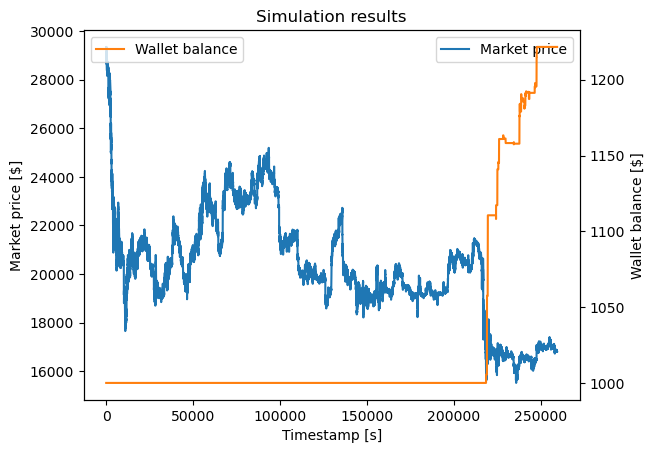

In [43]:
plot_sim_results(eval_prices, trajectory, twin_axes=True)